In [1]:
# pytorch로 LSTM모델 구현

# IMDB데이터 준비
import torch
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # 샘플 길이 100
val_seq = pad_sequences(val_input, maxlen=100)

train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

# 데이터 로더로 훈련세트 검증세트 준비
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=64, shuffle=False)


2025-09-01 13:51:14.526782: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 13:51:14.553889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-01 13:51:14.553920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-01 13:51:14.553941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-01 13:51:14.559383: I tensorflow/core/platform/cpu_feature_g

In [2]:
# 모델 구현
import torch.nn as nn

class IMDBLstm(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500,16) 
        self.lstm = nn.LSTM(16,8,batch_first=True, num_layers=2, dropout=0.2)
        self.dense = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x) # nn.LSTM 클래스는 순서대로 마지막층의 타임스텝별 은닉상태, 모든층의 마지막 은닉상태, 모든층의 마지막 셀상태 반환 
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [3]:
# 모델 객체 생성 및 GPU로 전달
model = IMDBLstm()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수와 옵티마이저 정의
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# 모델 훈련 코드
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets) # squeeze()로 크기가 1인 차원 삭제
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 검증 손실 계산
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets) # squeeze()로 크기가 1인 차원 삭제
            val_loss += loss.item()

    # 평균 훈련손실과 평균 검증 손실 계산 (데이터로더에 len()함수를 적용하면 배치 반복 횟수 반환)
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},",f"훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}") # 에포크 손실 출력

    # 조기 종료
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_2lstm_model.pt')
    else:
        early_stopping_counter += 1
    if early_stopping_counter >= patience:
        print(f"{epoch+1}번쨰 에포크에서 조기 종료되었습니다.")
        break

에포크:1, 훈련 손실:0.6891, 검증 손실:0.6731
에포크:2, 훈련 손실:0.6416, 검증 손실:0.6433
에포크:3, 훈련 손실:0.5930, 검증 손실:0.5733
에포크:4, 훈련 손실:0.5489, 검증 손실:0.5339
에포크:5, 훈련 손실:0.5146, 검증 손실:0.5105
에포크:6, 훈련 손실:0.4904, 검증 손실:0.4838
에포크:7, 훈련 손실:0.4766, 검증 손실:0.4729
에포크:8, 훈련 손실:0.4620, 검증 손실:0.4784
에포크:9, 훈련 손실:0.4531, 검증 손실:0.4650
에포크:10, 훈련 손실:0.4442, 검증 손실:0.4492
에포크:11, 훈련 손실:0.4365, 검증 손실:0.4562
에포크:12, 훈련 손실:0.4288, 검증 손실:0.4452
에포크:13, 훈련 손실:0.4250, 검증 손실:0.4442
에포크:14, 훈련 손실:0.4183, 검증 손실:0.4407
에포크:15, 훈련 손실:0.4132, 검증 손실:0.4354
에포크:16, 훈련 손실:0.4085, 검증 손실:0.4644
에포크:17, 훈련 손실:0.4077, 검증 손실:0.4292
에포크:18, 훈련 손실:0.4004, 검증 손실:0.4618
에포크:19, 훈련 손실:0.3968, 검증 손실:0.4284
에포크:20, 훈련 손실:0.3970, 검증 손실:0.4386
에포크:21, 훈련 손실:0.3921, 검증 손실:0.4374
21번쨰 에포크에서 조기 종료되었습니다.


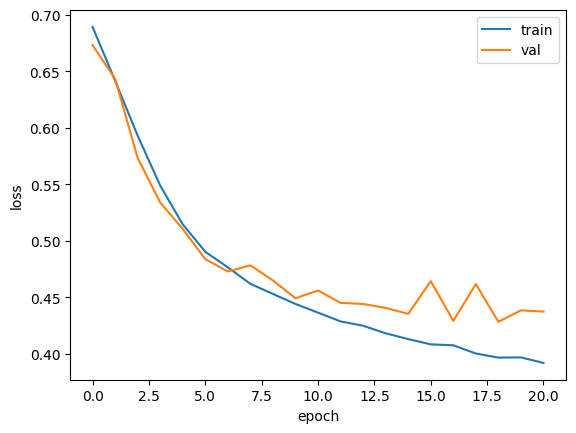

In [4]:
# 훈련손실 검증손실 그래프
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
# 검증 세트에 대한 모델 정확도 확인  
# outputs와 0.5를 비교하여 모델 출력이 양성,음성 클래스인지 기록한 불리언텐서 사용 후 targets와 비교하여 올바른 예측 개수 카운트
model.load_state_dict(torch.load('best_2lstm_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs > 0.5
        corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.8016


In [10]:
# 최종적으로 테스트세트에 대한 모델 성능 확인

test_seq = pad_sequences(test_input, maxlen=100)
test_seq = torch.tensor(test_seq)
test_target = torch.tensor(test_target, dtype=torch.float32)

test_dataset = TensorDataset(test_seq, test_target)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs > 0.5
        corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(test_dataset)
print(f"검증 정확도: {accuracy:.4f}")

/tmp/ipykernel_17340/3585810466.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_target = torch.tensor(test_target, dtype=torch.float32)


검증 정확도: 0.8054
